In [1]:
pip install numpy==1.26.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

print(np.__version__)

1.26.0


In [3]:
import logging
import os
import sys
import tempfile
from glob import glob

import torch
from PIL import Image
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import ArrayDataset, create_test_image_2d, decollate_batch, DataLoader
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
)
from monai.visualize import plot_2d_or_3d_image

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [4]:
import torch
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

device

device(type='mps')

In [5]:
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [6]:
import torch

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print(x)
else:
    print("MPS device not found.")

tensor([1.], device='mps:0')


Total number of samples in the dataset: 210
torch.Size([10, 3, 128, 128]) torch.Size([10, 1, 128, 128])


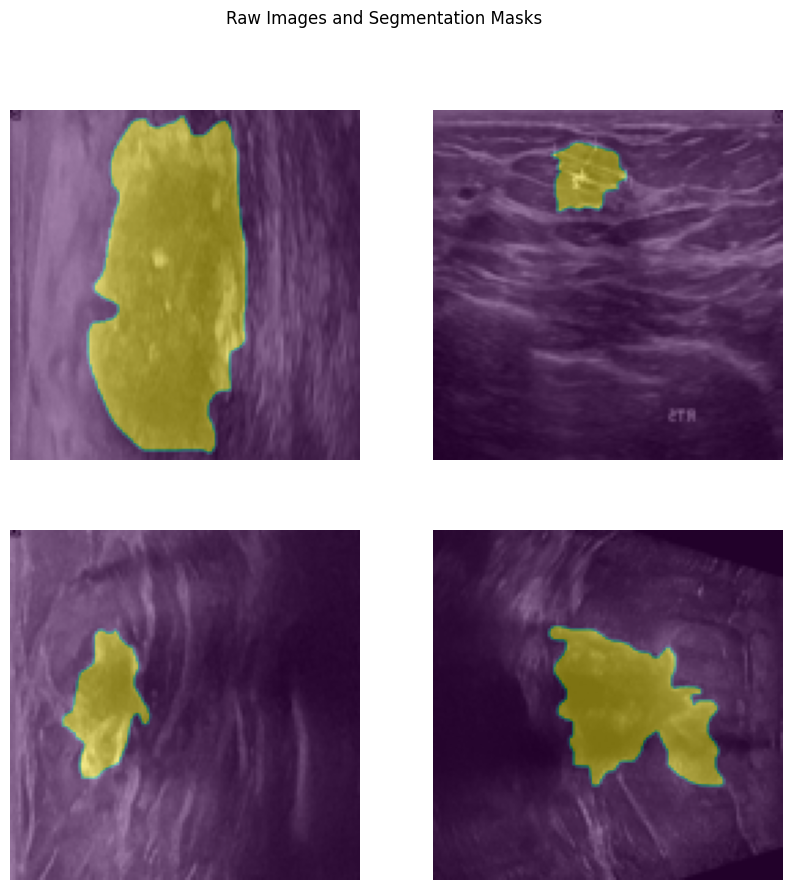

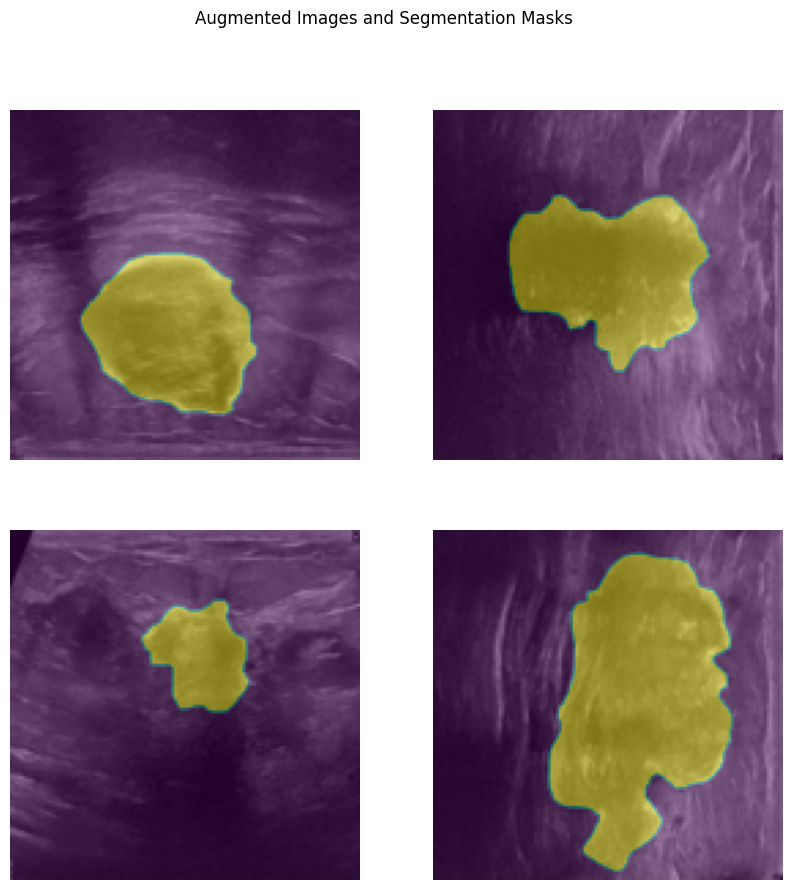

In [7]:
import os
import glob
import matplotlib.pyplot as plt
import monai
from monai.transforms import Compose, LoadImage, ScaleIntensity, RandSpatialCrop, RandRotate90, SpatialPad, Resize
from monai.data import ArrayDataset, DataLoader
from monai.metrics import DiceMetric, MeanIoU, ConfusionMatrixMetric
from monai.transforms import Activations, AsDiscrete
from torch.utils.tensorboard import SummaryWriter
import torch

tempdir = "/Users/nittin_murthi/Documents/VS_Code/MONAI-UNET/segmentation_data/malignant/"

# Define paths to image and mask directories
image_dir = os.path.join(tempdir, "image")
mask_dir = os.path.join(tempdir, "mask")

# Read image and mask file paths
images = sorted(glob.glob(os.path.join(image_dir, "*.png")))
masks = sorted(glob.glob(os.path.join(mask_dir, "*.png")))

if len(images) != len(masks):
    raise ValueError("The number of images and masks must be the same.")

# Print the total number of samples in the dataset
total_samples = len(images)
print(f"Total number of samples in the dataset: {total_samples}")

# Verify that images and masks are correctly matched
for img_path, mask_path in zip(images, masks):
    img_name = os.path.basename(img_path).split('.')[0].replace(" ", "")
    mask_name = os.path.basename(mask_path).split('.')[0].replace("_mask_merged", "").replace(" ", "")
    if img_name != mask_name:
        raise ValueError(f"Image and mask names do not match: {img_name} vs {mask_name}")
    
# Define transforms for image and segmentation
train_imtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        ScaleIntensity(),
        Resize((128, 128)),
        RandSpatialCrop((256, 256), random_size=False),
        #SpatialPad((128, 128), method='symmetric', mode='constant', constant_values=0),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
    ]
)
train_masktrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        ScaleIntensity(),
        Resize((128, 128)),
        RandSpatialCrop((256, 256), random_size=False),
        #SpatialPad((128, 128), method='symmetric', mode='constant', constant_values=0),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
    ]
)
val_imtrans = Compose([LoadImage(image_only=True, ensure_channel_first=True), ScaleIntensity()])
val_masktrans = Compose([LoadImage(image_only=True, ensure_channel_first=True), ScaleIntensity()])

# Define array dataset, data loader
check_ds = ArrayDataset(images, train_imtrans, masks, train_masktrans)
check_loader = DataLoader(check_ds, batch_size=10, num_workers=2, pin_memory=True)
im, msk = monai.utils.misc.first(check_loader)
print(im.shape, msk.shape)

# Display some raw images and their corresponding segmentation masks
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        idx = i * 2 + j
        axes[i, j].imshow(im[idx].permute(1, 2, 0).cpu().numpy())
        axes[i, j].imshow(msk[idx].squeeze().cpu().numpy(), alpha=0.5)
        axes[i, j].axis('off')
plt.suptitle("Raw Images and Segmentation Masks")
plt.show()

# Split the dataset into training and validation sets
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size
train_images, val_images = images[:train_size], images[train_size:]
train_masks, val_masks = masks[:train_size], masks[train_size:]

# Create a training data loader
train_ds = ArrayDataset(train_images, train_imtrans, train_masks, train_masktrans)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=8, pin_memory=torch.backends.mps.is_available())

# Create a validation data loader
val_ds = ArrayDataset(val_images, val_imtrans, val_masks, val_masktrans)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, pin_memory=torch.cuda.is_available())

# Display some augmented images and their corresponding segmentation masks
aug_images, aug_masks = next(iter(train_loader))
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        idx = i * 2 + j
        axes[i, j].imshow(aug_images[idx].permute(1, 2, 0).cpu().numpy())
        axes[i, j].imshow(aug_masks[idx].squeeze().cpu().numpy(), alpha=0.5)
        axes[i, j].axis('off')
plt.suptitle("Augmented Images and Segmentation Masks")
plt.show()

In [11]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

# Define metrics
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
mean_iou_metric = MeanIoU(include_background=True, reduction="mean", get_not_nans=False)
precision_metric = ConfusionMatrixMetric(include_background=True, metric_name="precision")
recall_metric = ConfusionMatrixMetric(include_background=True, metric_name="recall")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# Training loop
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = {'dice': [], 'iou': [], 'precision': [], 'recall': []}
val_metric_values = {'dice': [], 'iou': [], 'precision': [], 'recall': []}
writer = SummaryWriter()

for epoch in range(200):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{200}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_loader)}, train_loss: {loss.item():.4f}")
        
        outputs = [post_trans(i) for i in decollate_batch(outputs)]
        labels = [post_trans(i) for i in decollate_batch(labels)]
        dice_metric(y_pred=outputs, y=labels)
        mean_iou_metric(y_pred=outputs, y=labels)
        precision_metric(y_pred=outputs, y=labels)
        recall_metric(y_pred=outputs, y=labels)
    
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    writer.add_scalar("train_loss", epoch_loss, epoch + 1)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    dice = dice_metric.aggregate().item()
    mean_iou = mean_iou_metric.aggregate().item()
    epsilon = 1e-8
    precision = torch.nanmean(torch.tensor(precision_metric.aggregate()) + epsilon).item()
    recall = torch.nanmean(torch.tensor(recall_metric.aggregate()) + epsilon).item()
    dice_metric.reset()
    mean_iou_metric.reset()
    precision_metric.reset()
    recall_metric.reset()
    
    metric_values['dice'].append(dice)
    metric_values['iou'].append(mean_iou)
    metric_values['precision'].append(precision)
    metric_values['recall'].append(recall)
    
    print(f"Training Metrics - Epoch {epoch + 1}: Dice: {dice:.4f}, MeanIOU: {mean_iou:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
                val_outputs = model(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_trans(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                mean_iou_metric(y_pred=val_outputs, y=val_labels)
                precision_metric(y_pred=val_outputs, y=val_labels)
                recall_metric(y_pred=val_outputs, y=val_labels)
        
        val_dice = dice_metric.aggregate().item()
        val_mean_iou = mean_iou_metric.aggregate().item()
        val_precision = precision_metric.aggregate().item()
        val_recall = recall_metric.aggregate().item()
        dice_metric.reset()
        mean_iou_metric.reset()
        precision_metric.reset()
        recall_metric.reset()
        
        val_metric_values['dice'].append(val_dice)
        val_metric_values['iou'].append(val_mean_iou)
        val_metric_values['precision'].append(val_precision)
        val_metric_values['recall'].append(val_recall)
        
        print(f"Validation Metrics - Epoch {epoch + 1}: Dice: {val_dice:.4f}, MeanIOU: {val_mean_iou:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")
        
        if val_dice > best_metric:
            best_metric = val_dice
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), "best_metric_model.pth")
            print("saved new best metric model")

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

# Plotting metrics
epochs = range(1, 201)
plt.figure(figsize=(12, 8))
plt.plot(epochs, epoch_loss_values, label='Training Loss')
plt.plot(epochs[::val_interval], val_metric_values['dice'], label='Validation Dice')
plt.plot(epochs, metric_values['dice'], label='Training Dice')
plt.plot(epochs[::val_interval], val_metric_values['iou'], label='Validation MeanIOU')
plt.plot(epochs, metric_values['iou'], label='Training MeanIOU')
plt.plot(epochs[::val_interval], val_metric_values['precision'], label='Validation Precision')
plt.plot(epochs, metric_values['precision'], label='Training Precision')
plt.plot(epochs[::val_interval], val_metric_values['recall'], label='Validation Recall')
plt.plot(epochs, metric_values['recall'], label='Training Recall')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.title('Training and Validation Metrics')
plt.show()

----------
epoch 1/200
1/42, train_loss: 0.7839
2/42, train_loss: 0.6900
3/42, train_loss: 0.7370
4/42, train_loss: 0.7896
5/42, train_loss: 0.7626
6/42, train_loss: 0.7897
7/42, train_loss: 0.7996
8/42, train_loss: 0.7875
9/42, train_loss: 0.7217
10/42, train_loss: 0.6491
11/42, train_loss: 0.6482
12/42, train_loss: 0.6865
13/42, train_loss: 0.7620
14/42, train_loss: 0.7825
15/42, train_loss: 0.6645
16/42, train_loss: 0.7431
17/42, train_loss: 0.7596
18/42, train_loss: 0.7208
19/42, train_loss: 0.6879
20/42, train_loss: 0.7865
21/42, train_loss: 0.6944
22/42, train_loss: 0.8019
23/42, train_loss: 0.7255
24/42, train_loss: 0.6724
25/42, train_loss: 0.6148
26/42, train_loss: 0.6337
27/42, train_loss: 0.7089
28/42, train_loss: 0.5879
29/42, train_loss: 0.7279
30/42, train_loss: 0.5745
31/42, train_loss: 0.7729
32/42, train_loss: 0.8048
33/42, train_loss: 0.7735
34/42, train_loss: 0.7422
35/42, train_loss: 0.7085
36/42, train_loss: 0.7615
37/42, train_loss: 0.5869
38/42, train_loss: 0.601